# Atividade Prática 7

>### Igor Martinelli           9006336

>### Zoltán Hirata Jetsmen     9293272

## Para a presente prática será escolhido o conjunto de dados wine, que é um conjunto de dados de classificação que ja fora utilizado nas práticas anteriores. Além disso, será removido os exemplos da classe 3, de modo a tornar o problema binário.

In [301]:
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, datasets
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

In [265]:
wine = datasets.load_wine()
wine = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


>### Eliminando os exemplos da classe 2 de modo a tornar o problema binário.

In [266]:
 wine = wine[(wine.target == 0) | (wine.target == 1)]

## Função de classificação fornecida

In [267]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=10, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    #svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[], 'y_pred':[[]], 'y_test':[[]]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            ypred = []
            ytest = []
                  
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
            
            ypred.append(y_pred)
            ytest.append(y_test)
        results['y_pred'].append(ypred)
        results['y_test'].append(ytest)
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}



>## 1 - Ten fold cross validation

>>### Para o cálculo das medidas, será utilizada a matriz de confusão obtida na prática anterior.

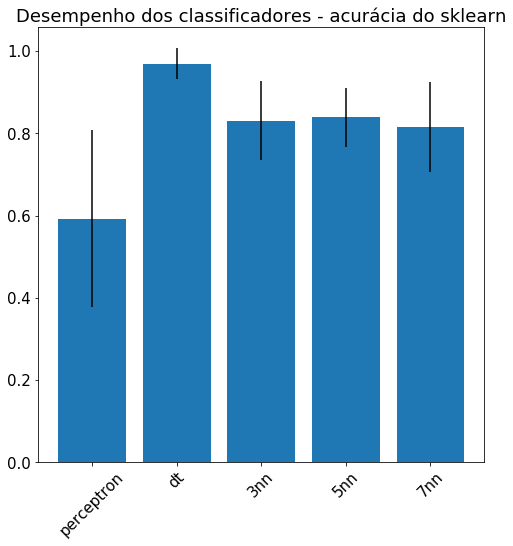

Matriz de confusão do classificador 1
[[5 0]
 [8 0]]

Matriz de confusão do classificador 2
[[5 0]
 [1 7]]

Matriz de confusão do classificador 3
[[5 1]
 [0 7]]

Matriz de confusão do classificador 4
[[6 1]
 [3 3]]

Matriz de confusão do classificador 5
[[6 1]
 [3 3]]



In [268]:
target = len(wine.columns) -1
columns = list(range(5))
clf_acc = classificacao(wine, columns, target, accuracy_score, 'acurácia do sklearn', folds=10)

cms = []
for i in range(5):
    print('Matriz de confusão do classificador ' + str(i+1))
    print(confusion_matrix(clf_acc['results']['y_test'][i+1][0], clf_acc['results']['y_pred'][i+1][0]))
    cms.append(confusion_matrix(clf_acc['results']['y_test'][i+1][0], clf_acc['results']['y_pred'][i+1][0]))
    print()

# Medidas de avalicação

In [280]:
for i in range(5):
    print('Classificador: ', (i+1))
    print()
    acc = (cms[i][0][0]+cms[i][1][1])/np.sum(cms[i])
    recall = (cms[i][0][0])/(cms[i][0][0]+cms[i][1][0])
    precision = (cms[i][0][0])/(cms[i][0][0]+cms[i][0][1])
    sensitivity = (cms[i][0][0])/(cms[i][0][0]+cms[i][1][0])
    specificity = (cms[i][1][1])/(cms[i][1][1]+cms[i][0][1])
    
    print('   Acurácia: %0.5f' % acc)
    print('   Recall: %0.5f' % recall)
    print('   Precisão: %0.5f' % precision)
    print('   Sensibilidade: %0.5f' % sensitivity)
    print('   Especificidade: %0.5f' % specificity)
    print()

Classificador:  1

   Acurácia: 0.38462
   Recall: 0.38462
   Precisão: 1.00000
   Sensibilidade: 0.38462
   Especificidade: nan

Classificador:  2

   Acurácia: 0.92308
   Recall: 0.83333
   Precisão: 1.00000
   Sensibilidade: 0.83333
   Especificidade: 1.00000

Classificador:  3

   Acurácia: 0.92308
   Recall: 1.00000
   Precisão: 0.83333
   Sensibilidade: 1.00000
   Especificidade: 0.87500

Classificador:  4

   Acurácia: 0.69231
   Recall: 0.66667
   Precisão: 0.85714
   Sensibilidade: 0.66667
   Especificidade: 0.75000

Classificador:  5

   Acurácia: 0.69231
   Recall: 0.66667
   Precisão: 0.85714
   Sensibilidade: 0.66667
   Especificidade: 0.75000



>## As medidas de avaliação foram calculadas com base nas matrizes de confusão calculadas na prática anterior.

>>## Quanto a acurácia, o classificador perceptron foi muito ruim com relação aos outrps, sendo que o 2 (decison tree) e o 3 (3-nn) foram os melhores.

>>## No recall, assim como na acurácia os classificadores 2 e 3 tiveram as melhoras medidas, sendo que as do 4 e 5 foram iguais e a do 1, ruim.

>>## Na precisão, vemos que apenas o classificador 5 teve um desempenho ruim, sendo que os demais, classificaram com 100% de certeza os exemplos positivos como sendo, de fato, positivos.

>>## Na sensibilidade vemos a porcentagem dos exemplos positivos que foram classificados como positivos e, podemos ver que o classificador 2 e 3 obteve melhores resultados novamente.

>>## Para a especificidade, podemos observar que, no geral, todos os classificadores foram bons, com exceção do primeiro que, por conter valores 0 na segunda coluna da matriz de confusão (FP e TN), não foi possível calcular a medida para o mesmo.

>## No geral, foi possível perceber que o classificador 1 (perceptron) é o pior de todos para este conjunto de dados, enquanto que o classificador 2 e 3 tiveram os valores das medidas muito bons.

>## 2 - Curva ROC e AUC

In [275]:
def classification(dataset):
    X = dataset.iloc[:, 0:-1]
    y = dataset.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    decision_tree = DecisionTreeClassifier(criterion='gini', 
                                                    splitter='best', 
                                                    min_samples_split=int(len(dataset)*0.1))
    
    knn_5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    
    decisition_tree_classifier = decision_tree.fit(X=X_train, y=y_train)
    knn_5_classifier = knn_5.fit(X=X_train, y=y_train)
    
    y_pred_knn = knn_5_classifier.predict_proba(X_test)
    y_pred_decision_tree = decisition_tree_classifier.predict_proba(X_test)

    # rótulos verdadeiros convertidos para array
    y_test = np.array(y_test)
    
    return {'y_knn': y_pred_knn, 'y_dt': y_pred_decision_tree, 'y_true': y_test}

## Dicionário com os valores dos classificadores knn com 5 vizinhos e decision tree, com  80% para treino e 20% dos exemplos para teste

In [276]:
y = classification(wine)

In [277]:
fpr_knn, tpr_knn, _ = roc_curve(y_true=y['y_true'], y_score=y['y_knn'][:, 1])
fpr_dt, tpr_dt, _ = roc_curve(y_true=y['y_true'], y_score=y['y_dt'][:, 1])

auc_knn = roc_auc_score(y_true=y['y_true'], y_score=y['y_knn'][:, 1])
auc_dt = roc_auc_score(y_true=y['y_true'], y_score=y['y_dt'][:, 1])

print('AUC para o algoritmo KNN (5-NN): %0.4f' % auc_knn)
print('AUC para o algoritmo Decision tree: %0.4f' % auc_dt)

AUC para o algoritmo KNN (5-NN): 0.9848
AUC para o algoritmo Decision tree: 0.9545


# Curva ROC para o KNN

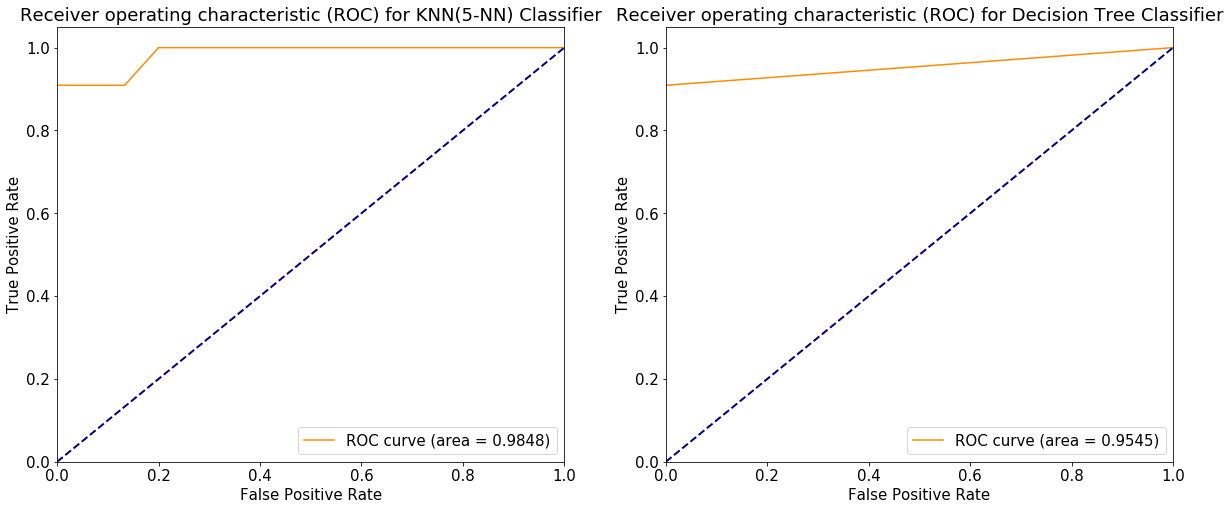

In [278]:
f = plt.figure(figsize=(20,8))
f.add_subplot(121)
plt.plot(fpr_knn, tpr_knn, color='darkorange', label='ROC curve (area = %0.4f)' % auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for KNN(5-NN) Classifier')
plt.legend(loc="lower right")

f.add_subplot(122)
plt.plot(fpr_dt, tpr_dt, color='darkorange', label='ROC curve (area = %0.4f)' % auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 15})
plt.show()

># 3 - Desempenho dos classificadores

>>## Com base nas curvas ROC e na área abaixo das curvas (AUC), podemos observar, para os algoritmos selecionados (Decision tree e 5-NN) que a área abaixo da curva teve um valor de aproximadamente 98,5% e 95,5%, o que é um cenário muito bom, pois, quanto mais próximo de 100%, isso significa que mais distante a curva ROC tende a estar da linha que representa a metade do gráfico, indicando uma eficiência muito grande no classificador utilizado. A AUC sintetiza a curva ROC nesse sentido, de que sua área indica bem a distância da curva para com a linha central

># 4 - Testes estatísticos

## Executando novamente a classificação com ten fold cross validation. Obs: apenas utilizou-se da função, no entanto, serão utilizados, para o teste, apenas dois classificadores, que são os mesmos utilizados na etapa 2.

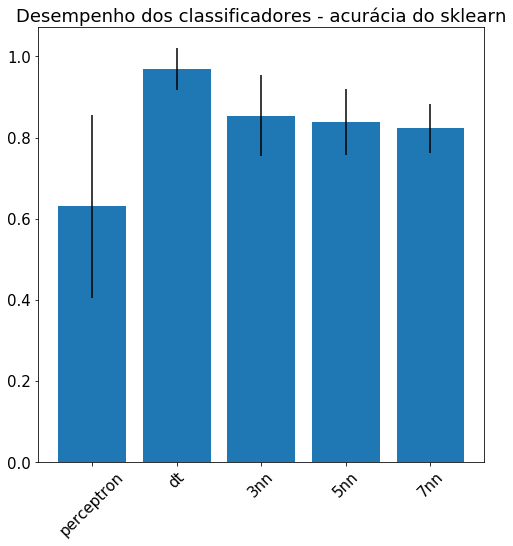

In [282]:
classifier = classificacao(wine, columns, target, accuracy_score, 'acurácia do sklearn', folds=10)

In [300]:
knn_5 = classifier['results']['5nn']
dt = classifier['results']['dt']

In [302]:
np.random.seed(12345678)

In [308]:
print(stats.ttest_ind(knn_5, dt))

Ttest_indResult(statistic=-4.123105625617663, pvalue=0.0006385428644434184)


## Como o p-valor obtido e igual a ~0.0006, rejeita-se a hipótese nula, dessa maneira pode-se concluir que os algoritmos são, de fato, diferentes e que, o algoritmo knn, com cinco vizinhos, é pior do que o de árvore de decisão, pois, como a estatística obteve um valor negativo, isso indica que a 'média' de acurácias do primeiro classificador é menor do que a do segundo, se considerarmos uma distribuição normal para eles. 